In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Model
import tensorflow.python.trackable.data_structures
import os
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.autograph.set_verbosity(0)

In [2]:
!pip install tensorflow_hub


     ---------------------------------------- 108.8/108.8 kB ? eta 0:00:00


In [4]:
!nvidia-smi

Fri Nov  4 12:32:46 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 517.40       Driver Version: 517.40       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:07:00.0  On |                  N/A |
|  0%   45C    P8    18W / 220W |    668MiB /  8192MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
data=pd.read_csv("Reviews.csv")

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [7]:
np.unique(data.Score,return_counts=True)

(array([1, 2, 3, 4, 5], dtype=int64),
 array([ 52268,  29769,  42640,  80655, 363122], dtype=int64))

In [8]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [9]:
data.loc[data['Score'] <=2, 'Score'] = 0
data.loc[data['Score'] > 3, 'Score'] = 1

In [10]:
data.drop(data[data['Score']==3].index,inplace=True)

In [11]:
data['len'] = data.Text.apply(lambda x: len(x.split()))

In [12]:
data = data.sample(n=500000, random_state=69, replace=True)

In [13]:
import re
data['Text']=data['Text'].apply(lambda row : re.sub('<.*?>','',row))

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
X_train, X_test, y_train, y_test = train_test_split(data[['Text','len']],data.Score, test_size=0.2, random_state=69, stratify=data.Score)

In [16]:
X_train.shape,X_test.shape

((400000, 2), (100000, 2))

In [17]:
max_seq_length = 55
tf.keras.backend.clear_session()
input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_word_ids")
                # ids of words
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask")
                # masking of ids
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="segment_ids")
                # segment of ids
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1", trainable=False)
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

bert_model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=pooled_output)

In [18]:
bert_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 55)]         0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 55)]         0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 55)]         0           []                               
                                                                                                  
 keras_layer (KerasLayer)       [(None, 768),        109482241   ['input_word_ids[0][0]',         
                                 (None, 55, 768)]                 'input_mask[0][0]',         

In [22]:
BertTokenizer = bert.bert_tokenization.FullTokenizer
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",
                            trainable=False)
vocabulary_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
to_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = BertTokenizer(vocabulary_file, to_lower_case)

In [20]:
!pip install bert-for-tf2

     ---------------------------------------- 41.2/41.2 kB ? eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.9-py3-none-any.whl size=30516 sha256=d4ff59508c6c199b364e72bc6eba972eb6a3d3dec6a3da10c069e9fcaa4bdab2
  Stored in directory: c:\users\xapo\appdata\local\pip\cache\wheels\6f\c7\91\f2b2c2b3cec30578c5de7c27ac99659a2013501dd66e7e3db0
  Created wheel for params-flow: filename=params_flow-0.8.2-py3-none-any.whl size=19458 sha256=6698fbaeb86b7d9f311f2af67eb74fde3894deee30430701bd2a670cb580d756
  Stored in directory: c:\users\xapo\appdata\local\pip\cache\wheels\be\17\6c\5c924411a614ee0a74b2dc4f04c9e61dacc4e60fe9854f4f70
  Created wheel for py-params: filename=py

In [21]:
from tensorflow.keras import layers
import bert

In [69]:
tokenizer.tokenize("don't be so judgmental")

['don', "'", 't', 'be', 'so', 'judgment', '##al']

In [70]:
tokenizer.convert_tokens_to_ids(tokenizer.tokenize("dont be so judgmental"))

[2123, 2102, 2022, 2061, 8689, 2389]

In [32]:
def tokenize_reviews(text_reviews):
    return tokenizer.convert_tokens_to_ids(tokenizer.tokenize(text_reviews))

In [33]:
def bert_preprocess(sentence,tokenizer,max_seq_len=512):
    tokens=[]
    masks=[]
    segments=[]
    for word in sentence:
        word=tokenizer.tokenize(word)
        word=word[:max_seq_len-2]
        seq=["[CLS]"] + word + ["[SEP]"]
        token = tokenizer.convert_tokens_to_ids(seq)
        padding_tokens=token+[0]*(max_seq_len-len(token))
        mask=[1]*len(seq)
        masking=mask+[0]*(max_seq_len-len(token))
        segment=np.zeros(max_seq_length)
        
        tokens.append(padding_tokens)
        masks.append(masking)
        segments.append(segment)
    return np.array(tokens),np.array(masks),np.array(segments)

In [34]:
import tokenization

In [35]:
bert_model.input

[<KerasTensor: shape=(None, 55) dtype=int32 (created by layer 'input_word_ids')>,
 <KerasTensor: shape=(None, 55) dtype=int32 (created by layer 'input_mask')>,
 <KerasTensor: shape=(None, 55) dtype=int32 (created by layer 'segment_ids')>]

In [36]:
bert_model.output

<KerasTensor: shape=(None, 768) dtype=float32 (created by layer 'keras_layer')>

In [37]:
X_train_tokens, X_train_mask, X_train_segment=bert_preprocess(X_train.Text.values,tokenizer,55)
X_test_tokens, X_test_mask, X_test_segment=bert_preprocess(X_test.Text.values,tokenizer,55)

In [38]:
X_train_pooled_output=bert_model.predict([X_train_tokens,X_train_mask,X_train_segment])
X_test_pooled_output=bert_model.predict([X_test_tokens,X_test_mask,X_test_segment])

3125/3125 [==============================] - 5270s 2s/step


In [39]:
from tensorflow.keras.layers import Input, Dense, Activation, Dropout
from tensorflow.keras.models import Model
import datetime
from sklearn.metrics import roc_auc_score

In [40]:
auc=[]
val_auc=[]
class LossHistory(tf.keras.callbacks.Callback):
    
    def on_train_begin(self, logs={}):
        self.history={'val_accuracy': []}


    def on_epoch_end(self, epoch, logs={}):
        ## on end of each epoch, we will get logs and update the self.history dict
        if logs.get('val_accuracy', -1) != -1:
            self.history['val_accuracy'].append(logs.get('val_accuracy'))
        auc_tr=(roc_auc_score(y_train,(self.model.predict(X_train_pooled_output))) )
        auc_test=(roc_auc_score (y_test, (self.model.predict(X_test_pooled_output) ) ) )
        print('\n  train_auc : ',auc_tr)
        print('  val_auc : ',auc_test)
        auc.append(auc_tr)
        val_auc.append(auc_test)
        loss=logs.get('loss')

In [41]:
#filepath="model1_save/weights-{epoch:02d}-{val_accuracy:.4f}.hdf5"
#checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=filepath, monitor='val_loss',  verbose=1, save_best_only=True, mode='auto')

history_own = LossHistory()

earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',mode='max', patience=2, verbose=1)

In [42]:
input = Input(shape=[768,],name='input_layer')
dense1=Dense(400, activation='relu',name='dense_1')(input)
dense2=Dense(220, activation='relu',name='dense_2')(dense1)
dense3=Dense(40, activation='relu',name='dense_3')(dense2)
output=Dense(1, activation='sigmoid',name='dense_4')(dense3)
model1 = Model(inputs=input, outputs=output)
tf.keras.utils.plot_model(model1,"model_1.png",show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [43]:
opt= tf.keras.optimizers.Adam(learning_rate=0.001)
model1.compile(optimizer=opt,loss=tf.keras.losses.BinaryCrossentropy(),metrics='accuracy')

In [44]:
X_test_pooled_output.shape

(100000, 768)

In [45]:
tf.keras.backend.clear_session()
model1.fit(X_train_pooled_output,y_train,validation_data=(X_test_pooled_output,y_test),epochs=50,callbacks=[history_own])

Epoch 1/50
3125/3125 [==============================] - 6s 2ms/step

  train_auc :  0.889939512523313
  val_auc :  0.8890018387433918
12500/12500 [==============================] - 106s 8ms/step - loss: 0.3060 - accuracy: 0.8715 - val_loss: 0.2913 - val_accuracy: 0.8846
Epoch 2/50
3125/3125 [==============================] - 6s 2ms/step

  train_auc :  0.8983748276801365
  val_auc :  0.8973084945388652
12500/12500 [==============================] - 101s 8ms/step - loss: 0.2820 - accuracy: 0.8823 - val_loss: 0.2840 - val_accuracy: 0.8805
Epoch 3/50
3125/3125 [==============================] - 7s 2ms/step

  train_auc :  0.9018635579149084
  val_auc :  0.9004446819029486
12500/12500 [==============================] - 107s 9ms/step - loss: 0.2754 - accuracy: 0.8850 - val_loss: 0.2663 - val_accuracy: 0.8888
Epoch 4/50
3125/3125 [==============================] - 8s 3ms/step

  train_auc :  0.9036174434487007
  val_auc :  0.9025157750049293
12500/12500 [==============================] - 104

Epoch 26/50
3125/3125 [==============================] - 7s 2ms/step

  train_auc :  0.9154539468565541
  val_auc :  0.9133235024923099
12500/12500 [==============================] - 116s 9ms/step - loss: 0.2512 - accuracy: 0.8954 - val_loss: 0.2516 - val_accuracy: 0.8943
Epoch 27/50
3125/3125 [==============================] - 7s 2ms/step

  train_auc :  0.9164174505103942
  val_auc :  0.9144112508986328
12500/12500 [==============================] - 104s 8ms/step - loss: 0.2512 - accuracy: 0.8952 - val_loss: 0.2472 - val_accuracy: 0.8977
Epoch 28/50
3125/3125 [==============================] - 8s 2ms/step

  train_auc :  0.91517300652861
  val_auc :  0.9131840003569475
12500/12500 [==============================] - 108s 9ms/step - loss: 0.2506 - accuracy: 0.8957 - val_loss: 0.2573 - val_accuracy: 0.8917
Epoch 29/50
3125/3125 [==============================] - 7s 2ms/step

  train_auc :  0.9156681292242889
  val_auc :  0.9135702520723846
12500/12500 [==============================] - 

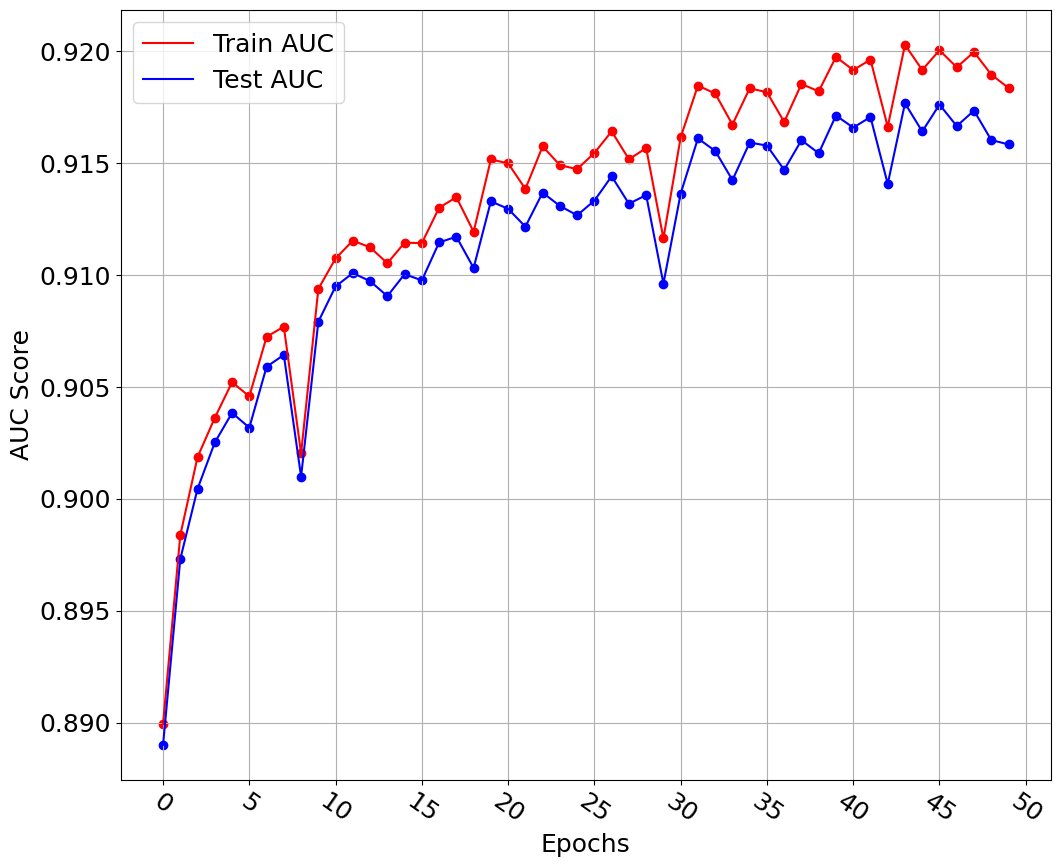

In [48]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(12,10))
plt.plot(np.arange(len(auc)),auc,color="red")
plt.plot(np.arange(len(auc)),val_auc,color='blue')
plt.scatter(np.arange(len(auc)),auc,color='red')
plt.scatter(np.arange(len(auc)),val_auc,color='blue')
plt.xticks(np.arange(0,len(auc)+1,5),rotation=-35)
plt.xlabel('Epochs')
plt.ylabel('AUC Score')
plt.legend(['Train AUC','Test AUC'])
plt.grid()
plt.show()